In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report,precision_recall_curve,make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from itertools import product
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Load data from a CSV file
file_path = '/data/processed/DPW_data_r3y.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
0,1,827262,1,f,open,0,DPW - Administration,Park Shelter,543,2024-03-12 10:50:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-03-12
1,2,720661,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-20 07:52:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-20
2,3,722010,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-24 07:44:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-24
3,4,846915,1,f,open,0,Police - Zones 1-6,Illegal Parking,417,2024-05-19 12:24:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-05-19
4,5,853708,1,f,open,0,DPW - Facilities,City Facility,375,2024-06-06 23:04:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-06-06


In [5]:
# Filter the dept == 'DPW - Street Maintenance'
dpw_sm = data[data['dept'] == 'DPW - Street Maintenance']
dpw_sm.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-07-08
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,Pittsburgh,NaN,4.200398e+10,6.0,NaN,NaN,40.446306,-80.027041,EXACT,2023-05-22


In [6]:
# Check duplicated data
dups = dpw_sm.duplicated()
dups.any()

np.False_

In [7]:
print(dpw_sm["request_type_name"].value_counts())
print(dpw_sm.describe())

request_type_name
Potholes                    10801
Litter, Public Property      6286
Snow/Ice removal             6135
Overgrowth                   3362
Street Cleaning/Sweeping     3237
                            ...  
Dumpster (on Street)            1
Repair City Steps               1
Storm Damage                    1
Recycling Violation             1
Brick or Block Repair           1
Name: count, Length: 65, dtype: int64
                 _id       group_id  num_requests   status_code  \
count   39090.000000   39090.000000  39090.000000  39090.000000   
mean   622270.571323  775751.960578      1.018854      1.041494   
std    203455.613641   95453.034213      0.197006      0.376899   
min        65.000000  620415.000000      1.000000      0.000000   
25%    611757.500000  693613.750000      1.000000      1.000000   
50%    682809.500000  774244.000000      1.000000      1.000000   
75%    755159.000000  857294.250000      1.000000      1.000000   
max    815687.000000  926116.00000

# **Part 3 Predict the high risk requests.**
Definition of "high risk": 
1. if the request is reported more than once, meaning that the request might be urgent or has been delayed
for some reason. ===> attribute 'num_requests' refers to the number of aggregated requests
- num_requests > 1 ===> is_multiple_request = 1
- otherwise ===> is_multiple_request = 0
2. if the the request didn't close and has been opened for over one month, it is high-risk.
- status_name = ["in progress","open","on hold"] and open days > 30 ===>  not_close_long_time_request = 1
- otherwise ===> not_close_long_time_request = 0

In [8]:
# feature exploration and engineering
# 1. repeat requests or not
# assume num_requests >1 as the sign of upgraded or high risk request
# num_requests: the 3-1-1 system clusters some requests about the same problem (for instance, the same pothole) together. The number of requests in the group is reflected in the num_requests field.

# calculate the number of num_requests ==1 and >1
num_gt1 = len(dpw_sm[dpw_sm['num_requests'] > 1])
num_eq1 = len(dpw_sm[dpw_sm['num_requests'] == 1])

print(f"num_requests > 1 : {num_gt1}")
print(f"num_requests = 1 : {num_eq1}")

# Create a copy and New target label: "is_multiple_request"
dpw_sm_part3 = dpw_sm.copy()
dpw_sm_part3['is_multiple_request'] = (dpw_sm_part3['num_requests'] > 1).astype(int)
print(f"Percentage of multiple requests:{num_gt1/(num_gt1+num_eq1)*100: .2f}%")

# Look at the type distribution of multiple requests
multiple_requests = dpw_sm_part3[dpw_sm_part3['is_multiple_request'] == 1]
multiple_requests['request_type_name'].value_counts().head(10)

num_requests > 1 : 537
num_requests = 1 : 38553
Percentage of multiple requests: 1.37%


request_type_name
Potholes                    151
Overgrowth                  136
Snow/Ice removal             75
Litter, Public Property      45
Tree Fallen Across Road      30
Street Cleaning/Sweeping     20
Drainage/Leak                19
Leaves/Street Cleaning       16
City Steps, Need Cleared     10
Litter Can, Public            7
Name: count, dtype: int64

In [9]:
# 2. closed requests or not
# if the the request didn't close and has been opened over 4 months, it is high-risk.
print(dpw_sm_part3["status_name"].value_counts())
not_close = dpw_sm_part3[dpw_sm_part3["status_name"].isin(["in progress","open","on hold"])].copy()
not_close["request_type_name"].value_counts().head(10)

status_name
closed         37111
in progress     1187
open             782
on hold           10
Name: count, dtype: int64


request_type_name
Litter, Public Property     489
Potholes                    349
Street Cleaning/Sweeping    162
Litter Can, Public          147
Overgrowth                  122
Drainage/Leak               112
Public Right of Way          89
Barricades                   81
Snow/Ice removal             67
Trail Maintenance            59
Name: count, dtype: int64

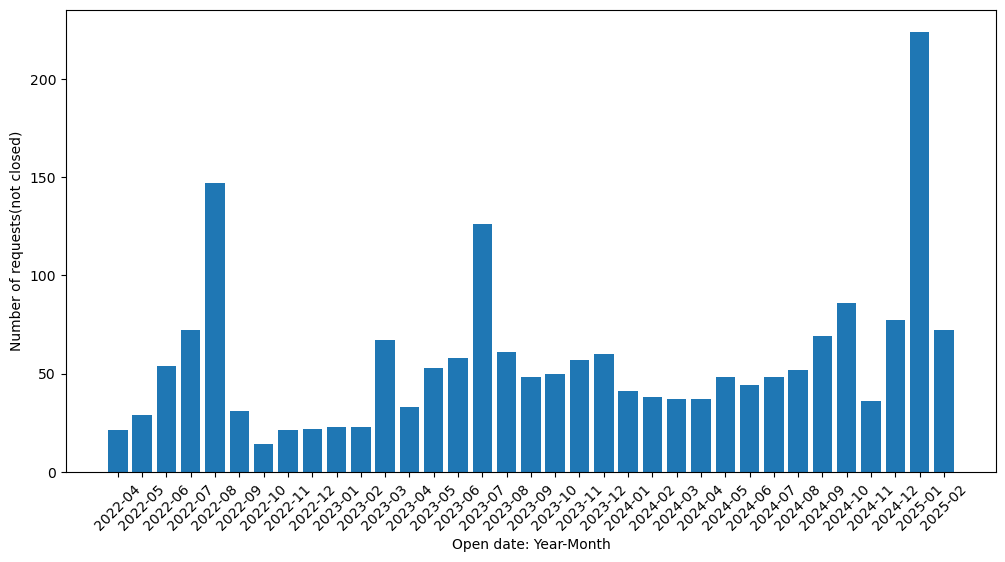

In [10]:
# see the month distribution of not close requests and decided to exclude the cases within 30 days of the high risk label
not_close['create_date_et'] = pd.to_datetime(not_close['create_date_et'])
not_close['create_year']=not_close['create_date_et'].dt.year
not_close['create_month']=not_close['create_date_et'].dt.month
monthly_counts = not_close.groupby(['create_year', 'create_month'])['num_requests'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts['create_year'].astype(str) + '-' + monthly_counts['create_month'].astype(str).str.zfill(2), monthly_counts['num_requests'])
plt.xlabel('Open date: Year-Month')
plt.ylabel("Number of requests(not closed)")
plt.xticks(rotation=45)
plt.show()

In [11]:
# create the new target label: not_close_long_time_request long_time ==> more than 30 days
dpw_sm_part3['create_date_et'] = pd.to_datetime(dpw_sm_part3['create_date_et'])
current_date = dpw_sm_part3['create_date_et'].max()
dpw_sm_part3['days_open'] = (current_date - dpw_sm_part3['create_date_et']).dt.days
filtered_requests = dpw_sm_part3[
    (dpw_sm_part3['status_name'] != 'closed') & (dpw_sm_part3['days_open']> 30)
]
dpw_sm_part3['not_close_long_time_request'] = 0  # 初始化为 0
dpw_sm_part3.loc[filtered_requests.index, 'not_close_long_time_request'] = 1
dpw_sm_part3.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date,is_multiple_request,days_open,not_close_long_time_request
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-07-08,0,577,1
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28,0,160,0
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05,0,152,0
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06,0,182,0
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,6.0,NaN,NaN,40.446306,-80.027041,EXACT,2023-05-22,0,624,1


In [12]:
count_1 = dpw_sm_part3['not_close_long_time_request'].sum()
print(count_1)
print(f"Percentage of 'not_close_long_time_request': {(count_1/len(dpw_sm_part3))*100:.2f}%")

1692
Percentage of 'not_close_long_time_request': 4.33%


In [13]:
# high risk label defined as above
dpw_sm_part3['high_risk'] = (
    (dpw_sm_part3['is_multiple_request'] == 1) |
    (dpw_sm_part3['not_close_long_time_request'] == 1)
).astype(int)


In [14]:
# extract create month and create one new categorical feature 'create_month'
dpw_sm_part3['create_month'] = dpw_sm_part3['create_date_et'].dt.month
# create 'is_weekend' feature
dpw_sm_part3['is_weekend'] = dpw_sm_part3['create_date_et'].dt.dayofweek.isin([5, 6]).astype(int)

# create 'is_working_hours' feature
dpw_sm_part3['is_working_hours'] = (
    (dpw_sm_part3['create_date_et'].dt.hour >= 9) & (dpw_sm_part3['create_date_et'].dt.hour < 17)
).astype(int)

In [15]:
dpw_sm_part3.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,longitude,geo_accuracy,date,is_multiple_request,days_open,not_close_long_time_request,high_risk,create_month,is_weekend,is_working_hours
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,NaN,NULL_COORDINATES,2023-07-08,0,577,1,1,7,1,1
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,NaN,NULL_COORDINATES,2024-08-28,0,160,0,0,8,0,0
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,NaN,NULL_COORDINATES,2024-09-05,0,152,0,0,9,0,1
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,NaN,NULL_COORDINATES,2024-08-06,0,182,0,0,8,0,1
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,-80.027041,EXACT,2023-05-22,0,624,1,1,5,0,1


In [16]:
dpw_sm_part3['neighborhood'].describe()

count         38593
unique           91
top       Brookline
freq           2019
Name: neighborhood, dtype: object

In [17]:
dpw_sm_part3['date'] = pd.to_datetime(dpw_sm_part3['date'])
daily_counts = (
    dpw_sm_part3
    .groupby(['neighborhood', 'date'])
    .size()
    .reset_index(name='daily_request_count')
)
daily_counts = daily_counts.sort_values(by=['neighborhood', 'date'])
daily_counts['requests_last_week'] = (
    daily_counts
    .groupby('neighborhood', group_keys=False)
    .apply(lambda g: g.set_index('date')
                     .rolling('7D')['daily_request_count']
                     .sum())
    .reset_index(level=0, drop=True)
)
daily_counts['requests_last_3_days'] = (
    daily_counts
    .groupby('neighborhood', group_keys=False)
    .apply(lambda g: g.set_index('date')
                     .rolling('3D')['daily_request_count']
                     .sum())
    .reset_index(level=0, drop=True)
)
print(daily_counts.head())

C:\Users\joranY\AppData\Local\Temp\ipykernel_12692\3262690716.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('date')


       neighborhood       date  daily_request_count  requests_last_week  \
0  Allegheny Center 2022-04-02                    1                 1.0   
1  Allegheny Center 2022-04-20                    1                 1.0   
2  Allegheny Center 2022-04-24                    1                 2.0   
3  Allegheny Center 2022-05-10                    1                 1.0   
4  Allegheny Center 2022-05-13                    1                 2.0   

   requests_last_3_days  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  


C:\Users\joranY\AppData\Local\Temp\ipykernel_12692\3262690716.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('date')


In [18]:
print(daily_counts.head())

       neighborhood       date  daily_request_count  requests_last_week  \
0  Allegheny Center 2022-04-02                    1                 1.0   
1  Allegheny Center 2022-04-20                    1                 1.0   
2  Allegheny Center 2022-04-24                    1                 2.0   
3  Allegheny Center 2022-05-10                    1                 1.0   
4  Allegheny Center 2022-05-13                    1                 2.0   

   requests_last_3_days  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  


In [19]:
dpw_sm_part3['date'] = pd.to_datetime(dpw_sm_part3['date']).dt.date
daily_counts['date'] = pd.to_datetime(daily_counts['date']).dt.date

In [20]:
dpw_sm_part3 = dpw_sm_part3.merge(
    daily_counts[['neighborhood', 'date', 'requests_last_week', 'requests_last_3_days']],
    on=['neighborhood', 'date'],
    how='left'
)
print(len(dpw_sm_part3))

39090


In [21]:
dpw_sm_part3.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,date,is_multiple_request,days_open,not_close_long_time_request,high_risk,create_month,is_weekend,is_working_hours,requests_last_week,requests_last_3_days
0,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,2023-07-08,0,577,1,1,7,1,1,NaN,NaN
1,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,2024-08-28,0,160,0,0,8,0,0,NaN,NaN
2,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,2024-09-05,0,152,0,0,9,0,1,NaN,NaN
3,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,2024-08-06,0,182,0,0,8,0,1,NaN,NaN
4,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,2023-05-22,0,624,1,1,5,0,1,NaN,NaN


In [22]:
merged_check = dpw_sm_part3.merge(
    daily_counts,
    on=['neighborhood', 'date'],
    how='left',
    indicator=True
)
print(merged_check['_merge'].value_counts())

_merge
both          38593
left_only       497
right_only        0
Name: count, dtype: int64


In [ ]:
weather = pd.read_csv('/data/processed/weather_data.csv')
weather['date'] = pd.to_datetime(weather['DATE']).dt.normalize()  
dpw_sm_part3['date'] = pd.to_datetime(dpw_sm_part3['date']).dt.normalize()
merged = dpw_sm_part3.merge(weather, on='date', how='left')


In [24]:
merged.columns

Index(['_id', 'group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy', 'date',
       'is_multiple_request', 'days_open', 'not_close_long_time_request',
       'high_risk', 'create_month', 'is_weekend', 'is_working_hours',
       'requests_last_week', 'requests_last_3_days', 'STATION', 'NAME', 'DATE',
       'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5',
       'WSF2', 'WSF5'],
      dtype='object')

*Model Training*
classify a specific request is high-risk or not

In [25]:
categorical_features = ['request_type_name', 'create_month', 'neighborhood', 'police_zone', 'council_district', 'ward'] 
numerical_features = ['is_weekend', 'is_working_hours','TAVG','PRCP','SNOW','AWND','requests_last_week',
       'requests_last_3_days'] # TAVG- temperature, PRCP- precipitation, SNOW- snow, AWND- wind

# impute and encode for categorical features
to_str = FunctionTransformer(lambda x: x.astype(str), validate=False)
categorical_transformer = Pipeline(steps=[
    ('to_str', to_str),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # 替换 NaN
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  
        ('cat', categorical_transformer, categorical_features) 
    ])

In [26]:
X = merged[categorical_features + numerical_features]
y = merged["high_risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_processed, y_train)



Model 0: random guess

In [27]:
pos_prob = np.mean(y_train)
np.random.seed(42)
y_pred = np.random.choice([0, 1], size=len(y_test), p=[1 - pos_prob, pos_prob])
y_prob = np.random.uniform(low=0.0, high=1.0, size=len(y_test)) 
print("Random baseline performance (based on training distribution):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Random baseline performance (based on training distribution):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7377
           1       0.06      0.06      0.06       441

    accuracy                           0.89      7818
   macro avg       0.50      0.50      0.50      7818
weighted avg       0.89      0.89      0.89      7818

Confusion matrix:
 [[6956  421]
 [ 416   25]]
AUC: 0.4810496065942531


In [28]:
models=[]
precision_scores = []
recall_scores = []
f1_scores = []

In [29]:
models.append("Baseline")
precision_scores.append(precision_score(y_test,y_pred))
recall_scores.append(recall_score(y_test,y_pred))
f1_scores.append(f1_score(y_test,y_pred))


Model 1: logistic regression

In [30]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear'],  
}

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), 
                           param_grid, 
                           scoring='f1', 
                           cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_


In [31]:
best_model.fit(X_train_resampled, y_train_resampled)
y_prob = best_model.predict_proba(X_test_processed)[:, 1]

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]

print(f"Best threshold: {best_threshold:.3f}, Best F1: {best_f1:.3f}")

Best threshold: 0.740, Best F1: 0.206


In [33]:
threshold = 0.74 
y_pred_adjusted = (y_prob >= threshold).astype(int)
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

AUC: 0.6900215691536206
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7377
           1       0.19      0.22      0.21       441

    accuracy                           0.90      7818
   macro avg       0.57      0.58      0.58      7818
weighted avg       0.91      0.90      0.91      7818

Confusion matrix:
 [[6957  420]
 [ 342   99]]


In [34]:
models.append("Logistic")
precision_scores.append(precision_score(y_test,y_pred_adjusted))
recall_scores.append(recall_score(y_test,y_pred_adjusted))
f1_scores.append(f1_score(y_test,y_pred_adjusted))


*Model 2 LightLGB*

In [36]:
lgb = LGBMClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=20,              # 搜索次数
    scoring='f1',           # 根据 f1-score 优化
    cv=3,                   # 3折交叉验证
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found:", random_search.best_params_)
print("Best F1 Score from CV:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 29495, number of negative: 29495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33059
[LightGBM] [Info] Number of data points in the train set: 58990, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F1 Score from CV: 0.9687523923336224


In [37]:
best_lgb = random_search.best_estimator_
y_prob = best_lgb.predict_proba(X_test_processed)[:, 1]

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]

print(f"Best threshold: {best_threshold:.3f}, Best F1: {best_f1:.3f}")

Best threshold: 0.202, Best F1: 0.289


In [39]:
threshold = best_threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

AUC: 0.7299470960947751
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7377
           1       0.32      0.26      0.29       441

    accuracy                           0.93      7818
   macro avg       0.64      0.61      0.62      7818
weighted avg       0.92      0.93      0.92      7818

Confusion matrix:
 [[7130  247]
 [ 325  116]]


In [40]:
models.append("Light GBM")
precision_scores.append(precision_score(y_test,y_pred_adjusted))
recall_scores.append(recall_score(y_test,y_pred_adjusted))
f1_scores.append(f1_score(y_test,y_pred_adjusted))

*Model 3 XGBoost*

In [41]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [43]:
scale_pos_weight = (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()

xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring=make_scorer(f1_score),
    cv=3,
    verbose=1,
    random_state=42
)
random_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters found:", random_search.best_params_)
print("Best F1 Score from CV:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best F1 Score from CV: 0.963975368838509


In [44]:
best_xgb = random_search.best_estimator_
y_prob = best_xgb.predict_proba(X_test_processed)[:, 1]

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]

print(f"Best threshold: {best_threshold:.3f}, Best F1: {best_f1:.3f}")

Best threshold: 0.260, Best F1: 0.263


In [46]:
threshold = best_threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

AUC: 0.7215069390460084
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7377
           1       0.36      0.21      0.26       441

    accuracy                           0.93      7818
   macro avg       0.66      0.59      0.61      7818
weighted avg       0.92      0.93      0.93      7818

Confusion matrix:
 [[7217  160]
 [ 350   91]]


In [47]:
models.append("XGBoost")
precision_scores.append(precision_score(y_test,y_pred_adjusted))
recall_scores.append(recall_score(y_test,y_pred_adjusted))
f1_scores.append(f1_score(y_test,y_pred_adjusted))

*Model Metrics*

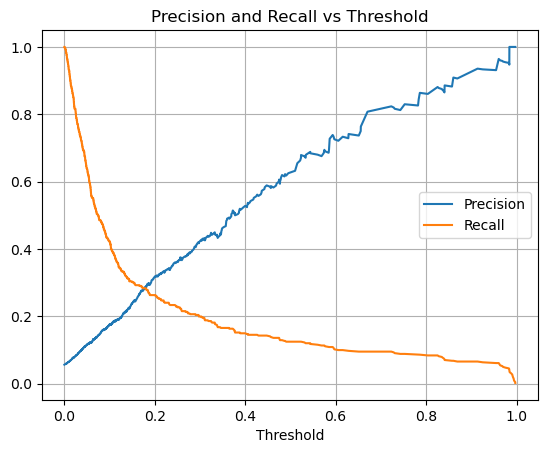

In [49]:
#  use lgb as the final model 
y_prob = best_lgb.predict_proba(X_test_processed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision and Recall vs Threshold")
plt.grid()
plt.show()

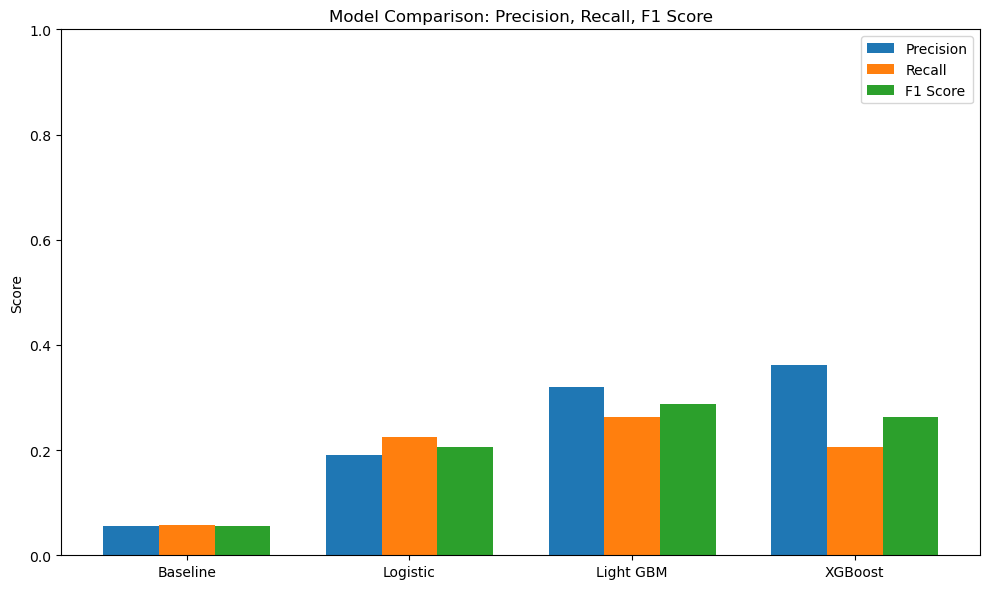

In [50]:
# draw the metricx 
x = np.arange(len(models))  # 模型数
width = 0.25  # 每组柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision_scores, width, label='Precision')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, f1_scores, width, label='F1 Score')

# 设置图表格式
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Precision, Recall, F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

Real-time Request Risk Classification (Classification)
- at specific time and neighborhood, will it have high risk requests of specific category or not

In [51]:
dpw_sm_part3.columns

Index(['_id', 'group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy', 'date',
       'is_multiple_request', 'days_open', 'not_close_long_time_request',
       'high_risk', 'create_month', 'is_weekend', 'is_working_hours',
       'requests_last_week', 'requests_last_3_days'],
      dtype='object')

In [52]:

# aggregate by week, neighborhood and type
dpw_sm_part3['year_week'] = dpw_sm_part3['date'].dt.to_period('W').astype(str)

agg_df = (
    dpw_sm_part3
    .groupby(['year_week', 'neighborhood', 'request_type_name'])
    .agg(
        high_risk_count=('high_risk', 'sum'),
        total_request=('high_risk', 'count')
    )
    .reset_index()
)

agg_df['label'] = (agg_df['high_risk_count'] > 0).astype(int)

In [53]:
print(agg_df.describe())
print(agg_df.head())

       high_risk_count  total_request         label
count     21279.000000   21279.000000  21279.000000
mean          0.094365       1.813666      0.084402
std           0.337418       3.036206      0.277997
min           0.000000       1.000000      0.000000
25%           0.000000       1.000000      0.000000
50%           0.000000       1.000000      0.000000
75%           0.000000       2.000000      0.000000
max           6.000000     118.000000      1.000000
               year_week      neighborhood            request_type_name  \
0  2022-03-28/2022-04-03  Allegheny Center      Litter, Public Property   
1  2022-03-28/2022-04-03         Arlington      Litter, Public Property   
2  2022-03-28/2022-04-03        Banksville                     Potholes   
3  2022-03-28/2022-04-03         Beechview                     Potholes   
4  2022-03-28/2022-04-03         Beechview  Tree Fallen Across Sidewalk   

   high_risk_count  total_request  label  
0                0              1     

In [ ]:
<!-- # construct all combinations of date, neighboor and request type, as those missing records are negative samples
weeks = dpw_sm_part3['year_week'].unique()
valid_combinations = dpw_sm_part3[['neighborhood', 'request_type_name']].dropna().drop_duplicates()

neighborhoods = valid_combinations['neighborhood'].unique()
request_types = valid_combinations['request_type_name'].unique()

index = pd.MultiIndex.from_product(
    [weeks, neighborhoods, request_types],
    names=['year_week', 'neighborhood', 'request_type_name']
)

agg_df_indexed = agg_df.set_index(['year_week', 'neighborhood', 'request_type_name'])

full_df = agg_df_indexed.reindex(index).reset_index()

full_df['label'] = full_df['label'].fillna(0).astype(int)
full_df['high_risk_count'] = full_df['high_risk_count'].fillna(0).astype(int)
full_df['total_request'] = full_df['total_request'].fillna(0).astype(int) -->

In [54]:
# time feature
agg_df['week_start'] = pd.to_datetime(agg_df['year_week'].str.slice(0, 10))
agg_df['week_number'] = agg_df['week_start'].dt.isocalendar().week
agg_df['month'] = agg_df['week_start'].dt.month

season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
agg_df['season'] = agg_df['month'].map(season_map)

agg_df['is_summer_break'] = agg_df['month'].isin([6, 7, 8]).astype(int)
agg_df['is_winter_break'] = agg_df['month'].isin([12, 1]).astype(int)

In [55]:
# historical data
agg_df.sort_values(by=['neighborhood', 'request_type_name', 'week_start'], inplace=True)
agg_df['request_last_1week'] = (
    agg_df
    .groupby(['neighborhood', 'request_type_name'])['total_request']
    .shift(1)
    .fillna(0)
)

agg_df['request_last_3week'] = (
    agg_df
    .groupby(['neighborhood', 'request_type_name'])['total_request']
    .rolling(window=3, min_periods=1)
    .sum()
    .shift(1)
    .reset_index(level=[0,1], drop=True)
    .fillna(0)
)

In [57]:
print(agg_df.describe())

       high_risk_count  total_request         label  \
count     21279.000000   21279.000000  21279.000000   
mean          0.094365       1.813666      0.084402   
min           0.000000       1.000000      0.000000   
25%           0.000000       1.000000      0.000000   
50%           0.000000       1.000000      0.000000   
75%           0.000000       2.000000      0.000000   
max           6.000000     118.000000      1.000000   
std           0.337418       3.036206      0.277997   

                          week_start  week_number         month  \
count                          21279      21279.0  21279.000000   
mean   2023-08-10 18:19:40.544198144    26.516331      6.526294   
min              2022-03-28 00:00:00          1.0      1.000000   
25%              2022-10-31 00:00:00         16.0      4.000000   
50%              2023-07-24 00:00:00         27.0      7.000000   
75%              2024-05-13 00:00:00         37.0      9.000000   
max              2025-02-03 00:00:0

In [58]:
# weather
weather['year_week'] = weather['date'].dt.to_period('W').astype(str)
weekly_weather = weather.groupby('year_week').agg({
    'TAVG': 'mean',
    'PRCP': 'sum',
    'SNOW': 'sum',
    'AWND': 'mean'
}).reset_index()
agg_df = agg_df.merge(weekly_weather, on='year_week', how='left')

In [59]:
weekly_weather.head()

,year_week,TAVG,PRCP,SNOW,AWND
0,2021-12-27/2022-01-02,46.500000,0.94,0.0,8.835000
1,2022-01-03/2022-01-09,26.857143,0.80,2.4,9.810000
2,2022-01-10/2022-01-16,25.571429,0.34,3.7,9.011429
3,2022-01-17/2022-01-23,23.142857,0.59,9.7,10.290000
4,2022-01-24/2022-01-30,17.428571,0.32,3.4,7.030000


In [60]:
print(agg_df.head())

               year_week      neighborhood request_type_name  high_risk_count  \
0  2023-05-29/2023-06-04  Allegheny Center        Barricades                0   
1  2023-08-07/2023-08-13  Allegheny Center        Barricades                0   
2  2023-08-21/2023-08-27  Allegheny Center        Barricades                1   
3  2023-12-04/2023-12-10  Allegheny Center        Barricades                0   
4  2024-05-27/2024-06-02  Allegheny Center        Barricades                1   

   total_request  label week_start  week_number  month  season  \
0              1      0 2023-05-29           22      5  Spring   
1              1      0 2023-08-07           32      8  Summer   
2              1      1 2023-08-21           34      8  Summer   
3              1      0 2023-12-04           49     12  Winter   
4              1      1 2024-05-27           22      5  Spring   

   is_summer_break  is_winter_break  request_last_1week  request_last_3week  \
0                0                0  

In [61]:
agg_categorical_features = ['season', 'neighborhood', 'request_type_name',]

agg_numerical_features = [
    'week_number', 'month', 'TAVG', 'PRCP', 'SNOW', 'AWND',
    'request_last_1week', 'request_last_3week', 'is_summer_break', "is_winter_break"
]
categorical_transformer = Pipeline(steps=[
    ('to_str', to_str),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), agg_numerical_features),
    ('cat', categorical_transformer, agg_categorical_features)
])

In [62]:
# Split the training and testing data based on the create_date
cutoff = pd.to_datetime("2024-04-01")

train_df = agg_df[agg_df['week_start'] < cutoff].copy()
test_df = agg_df[agg_df['week_start'] >= cutoff].copy()

# downsample
X_train = train_df[agg_categorical_features + agg_numerical_features]
y_train = train_df['label']

X_test = test_df[agg_categorical_features + agg_numerical_features]
y_test = test_df['label']

# resample
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

Model 0: random guess

In [63]:
pos_prob = np.mean(y_train)
np.random.seed(42)
y_pred = np.random.choice([0, 1], size=len(y_test), p=[1 - pos_prob, pos_prob])
y_prob = np.random.uniform(low=0.0, high=1.0, size=len(y_test)) 
print("Random baseline performance (based on training distribution):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Random baseline performance (based on training distribution):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5857
           1       0.08      0.08      0.08       514

    accuracy                           0.85      6371
   macro avg       0.50      0.50      0.50      6371
weighted avg       0.85      0.85      0.85      6371

Confusion matrix:
 [[5356  501]
 [ 471   43]]
AUC: 0.5050865338558604


In [64]:
agg_models=[]
agg_precision_scores = []
agg_recall_scores = []
agg_f1_scores = []

In [65]:
agg_models.append("Baseline")
agg_precision_scores.append(precision_score(y_test,y_pred))
agg_recall_scores.append(recall_score(y_test,y_pred))
agg_f1_scores.append(f1_score(y_test,y_pred))

Model 1: logistic

In [66]:
logic_classifier=LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
logic_classifier.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [67]:
y_logic_prob = logic_classifier.predict_proba(X_test_processed)[:, 1]
best_f1 = 0
best_thresh = 0.5
for threshold in np.arange(0.1, 0.9, 0.02):
    y_pred_thresh = (y_logic_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = threshold

print(f"Best threshold: {best_thresh:.3f}, Best F1: {best_f1:.3f}")

Best threshold: 0.480, Best F1: 0.168


In [68]:
final_logic_pred = (y_logic_prob >= best_thresh).astype(int)

print("AUC:", roc_auc_score(y_test, y_logic_prob))
print("F1 score:", f1_score(y_test, final_logic_pred))
print("Precision:", precision_score(y_test, final_logic_pred))
print("Recall:", recall_score(y_test, final_logic_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_logic_pred))

AUC: 0.5619711423159889
F1 score: 0.16779799076839533
Precision: 0.0975071000315557
Recall: 0.6011673151750972
Confusion Matrix:
 [[2997 2860]
 [ 205  309]]


In [69]:
agg_models.append("Logistic")
agg_precision_scores.append(precision_score(y_test,final_logic_pred))
agg_recall_scores.append(recall_score(y_test,final_logic_pred))
agg_f1_scores.append(f1_score(y_test,final_logic_pred))

Model 2: Light GBM

Model 3: XGBoost

Model 4: Random Forest

In [70]:
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()

lgb_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

xgb_model.fit(X_resampled, y_resampled)
rf_model.fit(X_resampled, y_resampled)
lgb_model.fit(X_resampled, y_resampled)

def find_best_threshold(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # 加1e-10防止除零
    best_index = np.argmax(f1_scores)
    return thresholds[best_index], f1_scores[best_index]

y_prob_rf = rf_model.predict_proba(X_test_processed)[:, 1]
best_thresh_rf, best_f1_rf = find_best_threshold(y_test, y_prob_rf)

y_prob_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]
best_thresh_xgb, best_f1_xgb = find_best_threshold(y_test, y_prob_xgb)

y_prob_lgb = lgb_model.predict_proba(X_test_processed)[:, 1]
best_thresh_lgb, best_f1_lgb = find_best_threshold(y_test, y_prob_lgb)

print(f"Random Forest - Best Threshold: {best_thresh_rf:.3f}, Best F1: {best_f1_rf:.3f}")
print(f"XGBoost - Best Threshold: {best_thresh_xgb:.3f}, Best F1: {best_f1_xgb:.3f}")
print(f"LightGBM - Best Threshold: {best_thresh_lgb:.3f}, Best F1: {best_f1_lgb:.3f}")

d:\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 13626, number of negative: 13626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14419
[LightGBM] [Info] Number of data points in the train set: 27252, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Random Forest - Best Threshold: 0.160, Best F1: 0.158
XGBoost - Best Threshold: 0.150, Best F1: 0.162
LightGBM - Best Threshold: 0.166, Best F1: 0.166


In [71]:
final_lgb_pred = (y_prob_lgb >= best_thresh_lgb).astype(int)
agg_models.append("LightGBM")
agg_precision_scores.append(precision_score(y_test, final_lgb_pred))
agg_recall_scores.append(recall_score(y_test, final_lgb_pred))
agg_f1_scores.append(f1_score(y_test, final_lgb_pred))

final_xgb_pred = (y_prob_xgb >= best_thresh_xgb).astype(int)
agg_models.append("XGBoost")
agg_precision_scores.append(precision_score(y_test, final_xgb_pred))
agg_recall_scores.append(recall_score(y_test, final_xgb_pred))
agg_f1_scores.append(f1_score(y_test, final_xgb_pred))

final_rf_pred = (y_prob_rf >= best_thresh_rf).astype(int)
agg_models.append("Random Forest")
agg_precision_scores.append(precision_score(y_test, final_rf_pred))
agg_recall_scores.append(recall_score(y_test, final_rf_pred))
agg_f1_scores.append(f1_score(y_test, final_rf_pred))

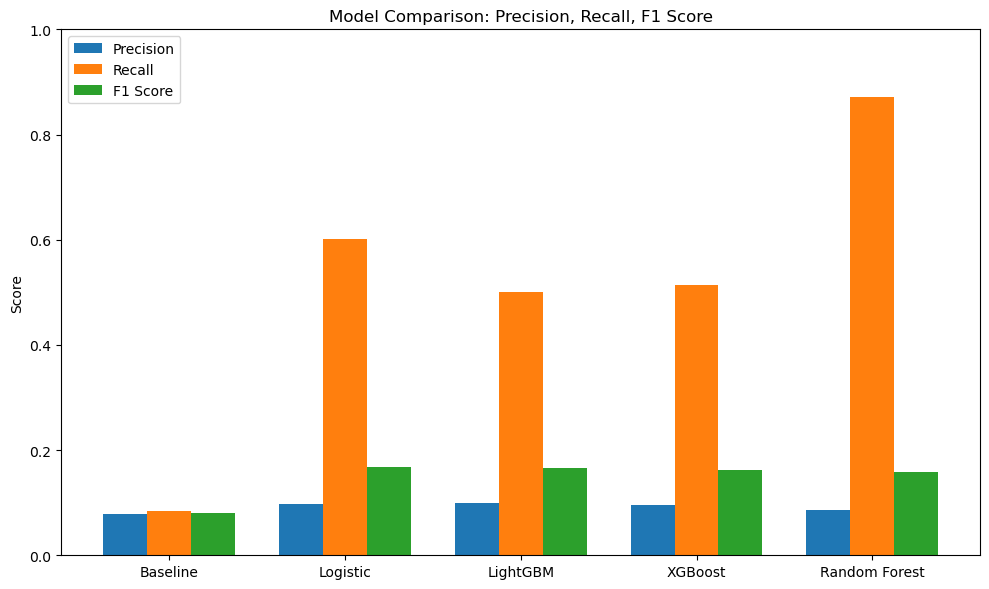

In [72]:
# draw the metricx 
x = np.arange(len(agg_models))  # 模型数
width = 0.25  # 每组柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, agg_precision_scores, width, label='Precision')
ax.bar(x, agg_recall_scores, width, label='Recall')
ax.bar(x + width, agg_f1_scores, width, label='F1 Score')

# 设置图表格式
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Precision, Recall, F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(agg_models)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()